# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.018154,False,0.091142
1,-1.512420,False,-0.853129
2,-1.395825,False,-1.936114
3,-0.917918,False,-0.893161
4,-1.903649,False,-1.293428
...,...,...,...
995,-1.724468,False,-2.708966
996,-1.743093,False,-2.041571
997,0.444876,True,5.298763
998,-0.674423,False,-2.041351


<AxesSubplot: xlabel='v0'>

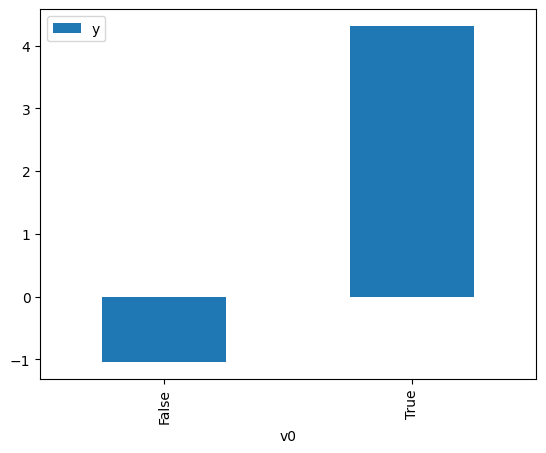

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

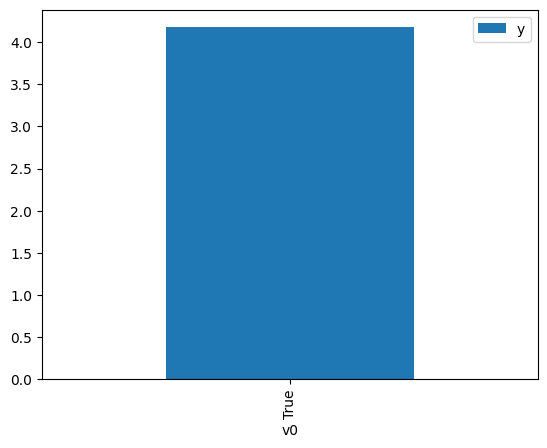

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.671413,False,-1.294921,0.983353,1.016929
1,-2.093640,False,-2.615018,0.993829,1.006209
2,-0.233466,False,0.307473,0.659892,1.515400
3,-0.503291,False,-0.481747,0.786474,1.271498
4,-1.843787,False,-1.425071,0.988885,1.011240
...,...,...,...,...,...
995,-0.240080,False,-0.212957,0.663409,1.507365
996,-0.876406,False,-1.101371,0.899363,1.111899
997,-0.245924,False,-0.059617,0.666502,1.500370
998,-0.406259,False,-0.315058,0.745223,1.341880


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.610295,True,5.088017,0.792753,1.261427
1,-1.526416,True,2.943770,0.023332,42.858865
2,-0.366196,True,2.863772,0.273265,3.659456
3,-1.526416,True,2.943770,0.023332,42.858865
4,0.645247,True,5.337534,0.806063,1.240598
...,...,...,...,...,...
995,-0.695829,True,4.409221,0.146642,6.819345
996,-1.169433,True,4.395616,0.052837,18.926251
997,-0.635942,True,4.825545,0.165354,6.047641
998,0.663973,True,5.463690,0.812923,1.230129


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.902
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              4609.
Date:                Thu, 15 Jun 2023   Prob (F-statistic):                        0.00
Time:                        12:22:28   Log-Likelihood:                         -1405.8
No. Observations:                1000   AIC:                                      2816.
Df Residuals:                     998   BIC:                                      2825.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.1900      0.024     50.387      0.000       1.144       1.236
x2             4.9630      0.064     77.772      0.000       4.838       5.088
==============================================================================
Omnibus:                        1.352   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                1.240
Skew:                          -0.080   Prob(JB):                        0.538
Kurtosis:                       3.065   Cond. No.                         2.71
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""